# NAVIX 101

This tutorial will guide you through the basics of using NAVIX. You will learn:
- How to create a `navix.Environment`,
- A vanilla, suboptimal interaction with it
- How to `jax.jit` compile the environment for faster execution
- How to run batched simulations

## Installation

For a full guide on how to install NAVIX and its dependencies, please refer to the [official installation guide](../install/index.html)
For a quickstart, you can install NAVIX via pip:
```bash
pip install navix
```

This will provide a standard CPU-based JAX installation. If you want to use a GPU, please [install JAX](https://github.com/google/jax/?tab=readme-ov-file#installation) with the appropriate backend.

## Creating an Environment

NAVIX provides a variety of MiniGrid environments.
You can find an exhaustive list [here](../home/environments.html). 
If the environment you are looking for is not listed, please open an new [feature request](https://github.com/epignatelli/navix/issues/new?assignees=&labels=enhancement&template=feature_request.md).

Now, let's create a simple DoorKey environment. The syntax is similar to the usual `gym.make`.

(64, 64, 3)


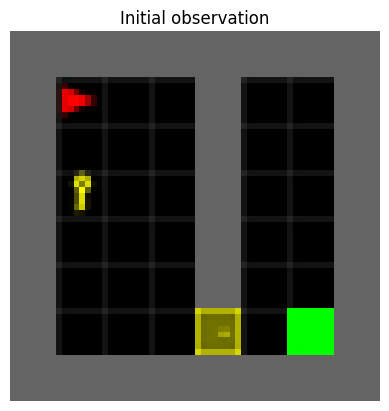

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import navix as nx

# Create the environment
env = nx.make('Navix-DoorKey-8x8-v0', observation_fn=nx.observations.rgb)
key = jax.random.PRNGKey(0)
timestep = env.reset(key)

def render(obs, title):
    plt.imshow(obs)
    plt.title(title)
    plt.axis('off')
    plt.show()

print(timestep.observation.shape)
render(timestep.observation, "Initial observation")

**Take-home message:**
1. To sample an initial environment state (`timestep`), we need to pass the `key` (seed) argument to the environment constructor. This is because NAVIX uses JAX's PRNGKey to generate random numbers. You can read more here
2. `env.reset` returns a [`navix.Timestep`]() object, which contains all the useful information.

## The environment interface

We can now simulate a sequence of actions in the environment. For this example, we'll make the agent take random actions.

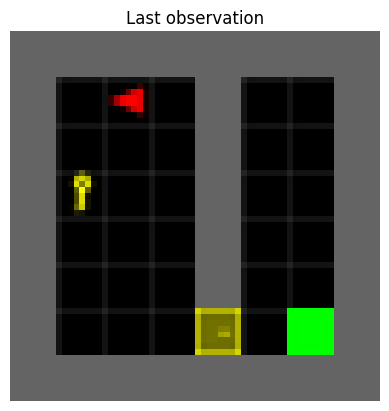

In [3]:
def unroll(key, num_steps=5):
    timestep = env.reset(key)
    actions = jax.random.randint(key, (num_steps,), 0, env.action_space.n)

    steps = [timestep]
    for action in actions:
        timestep = env.step(timestep, action)
        steps.append(timestep)

    return steps

# Unroll and print steps
steps = unroll(key, num_steps=5)
render(steps[-1].observation, "Last observation")


**Take home message:**
1. `env.step`, take two arguments: the current state of the environment (the `timestep`), and the action to take, and returns the new environment state.
2. Despite `env.step` being stochastic, it does not take a `key` argument. This is because NAVIX manages the PRNGKey internally.
3. You can still sample different environments by sampling different `keys` when creating the environment.

This way of using NAVIX is suboptimal (and probably slower than using `gym`), as it does not take advantage of JAX's JIT compiler. We'll see how to do that in the next section.

## `Optimizing with JAX`

One of the major perks of NAVIX is its performance optimization capabilities through JAX. We can use JAX's `jit` and `vmap` to compile and parallelize our simulation code.
We can compile the `step` function to make it faster. This is done by using the `jax.jit` decorator.

### JIT Compilation

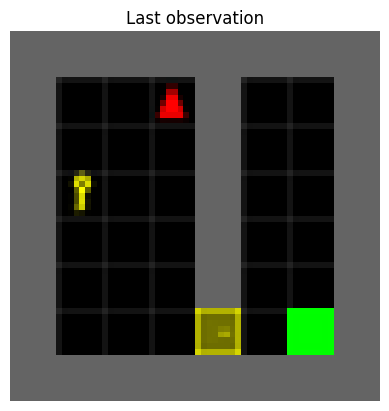

In [4]:
@jax.jit
def env_step_jit(timestep, action):
    return env.step(timestep, action)

def unroll_jit_step(key, num_steps=10):
    timestep = env.reset(key)
    actions = jax.random.randint(key, (num_steps,), 0, env.action_space.n)

    steps = [timestep]
    for action in actions:
        timestep = env_step_jit(timestep, action)
        steps.append(timestep)

    return steps

# Example usage
steps = unroll_jit_step(key, num_steps=10)
render(steps[-1].observation, "Last observation")

Let's compare the two head to head.

In [5]:
%timeit -n 1 -r 3 unroll(key, num_steps=10)

27.4 s ± 130 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [6]:
%timeit -n 1 -r 3 lambda: unroll_jit_step(key, num_steps=10)[-1].block_until_ready()

328 ns ± 153 ns per loop (mean ± std. dev. of 3 runs, 1 loop each)


Notice that it's roughly in the order of $10^9$ times faster compared to its unjitted counterpart.

But that's not the end of the story.
We can go even further and `jit` the whole simulation loop, which improves performance even more.

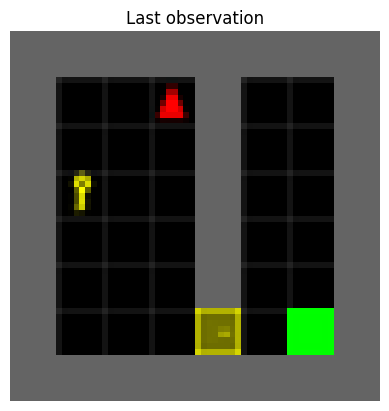

In [3]:
def unroll_scan(key, num_steps=10):
    timestep = env.reset(key)
    actions = jax.random.randint(key, (num_steps,), 0, env.action_space.n)

    timestep, _ = jax.lax.scan(
        lambda timestep, action: (env.step(timestep, action), ()),
        timestep,
        actions,
        unroll=10,
    )
    return timestep


# Example usage
unroll_jit_loop = jax.jit(unroll_scan, static_argnums=(1,))
timestep = unroll_jit_loop(key, num_steps=10)
render(timestep.observation, "Last observation")

In [11]:
%timeit -n 10 -r 5 unroll_jit_step(key, num_steps=10)

40.5 ms ± 1.49 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [12]:
%timeit -n 10 -r 5 unroll_jit_loop(key, num_steps=10).t.block_until_ready()

353 µs ± 71.3 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


We improved the performance by three more orders of magnitude, and we are at $10^12$.
This is because we are now compiling the whole simulation loop, not just the `step` function.

That's still not the end of the story. We can improve the performance even more by using `jax.vmap` to parallelize multiple environment simulations.

### Batched environments

We can run multiple simulations in parallel using `vmap`.

In [10]:
# Let's compile the function ahead of time
num_envs = 32
keys = jax.random.split(key, num_envs)
unroll_batched = jax.jit(jax.vmap(unroll_scan, in_axes=(0, None)), static_argnums=(1,)).lower(keys, 10).compile()

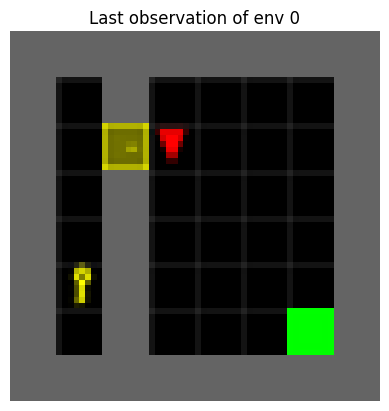

Batch size of the results 32


In [17]:
# and run it
last_steps = unroll_batched(keys)
render(last_steps.observation[0], "Last observation of env 0")
print("Batch size of the results", last_steps.reward.shape[0])

We can benchmark the performance of the batched simulation as well.

In [19]:
%timeit -n 10 -r 5 unroll_batched(keys).t.block_until_ready()

686 µs ± 215 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


Which takes roughly twice as long as the single simulation. An increment of $16\times$, roughly.

And we can scale this up to as many simulations as we want.
We get to **32768 environments** on a NVIDIA A100 GPU 80Gb.

Feel free to scale this up if you are GPU-richer.

In [29]:
# Let's compile the function ahead of time
num_envs = 32768
keys = jax.random.split(key, num_envs)
unroll_batched = jax.jit(jax.vmap(unroll_scan, in_axes=(0, None)), static_argnums=(1,)).lower(keys, 10).compile()

In [30]:
%timeit -n 10 -r 5 unroll_batched(keys).t.block_until_ready()

8.46 ms ± 1.06 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


That's a $(32768 * 10) / 0.00846 = 387,218,045$ : a bit less than $400M$ frames per second.

## Conclusion

This tutorial demonstrated the basic usage and key features of NAVIX, including environment creation, running simulations, performance optimization with JAX.
We wet from running a single environment in around 27s, to running 32768 environment in roughly around 8ms, with a throughput of **400M fps**.
In comparison, MiniGrid runs at roughly **3K fps**.

Check the [NAVIX paper](TODO) for more details on the performance of NAVIX.
For more advanced usage and examples, refer to the [NAVIX examples](https://github.com/epignatelli/navix/examples).

[In the next tutorial](ppo.html) we will see how to train a simple PPO agent on a NAVIX environment.